# Collision likelihood

Let's consider a multi-device IoT scenario with both Poisson HMMs and Discrete HMMs.
The challenge of detecting collision likelihood becomes a structured learning problem.

### Problem Definition

- Inputs: Base station sees a time series of observed signals with possible collisions.

- Goal: Learn a model that predicts the probability of collision at each time step.

- Devices:
    - 20 devices with categorical emissions (e.g., Discrete HMM).
    - 5 devices with count-based Poisson emissions (e.g., Poisson HMM).

In [1]:
%%capture
!pip install scikit-learn
!pip install torch
!pip install tqdm

In [2]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
np.random.seed(42)

## Step 1: Simulate Emissions

Simulate each device independently.

Sum up emissions and apply a collision function: If more than one device emits at the same time → collision Else → base station sees total emission.

In [4]:
from devices import SimpleHMM as DiscreteHMM
from devices import PoissonHMM

In [5]:
# Parameters
T = 1000
n_discrete = 20
n_poisson = 5

# HMM models (same for all devices of each type)
A_disc = np.array([[0.97, 0.03],   # idle → idle with high probability
                   [0.7, 0.3]])    # active → idle more likely than staying active

B_disc = np.array([[0.99, 0.01, 0.0],   # idle emits 0 with very high probability
                   [0.7, 0.25, 0.05]])  # active: mostly emits 0–1, rarely 2
pi_disc = [1.0, 0.0]

# Poisson-based HMM
A_pois = np.array([[0.98, 0.02],   # idle → idle is very likely
                   [0.6, 0.4]])    # active → idle more likely than staying active

lambda_pois = [0.05, 1.0]          # lower emission intensity

pi_pois = [1.0, 0.0]

In [6]:
def sample_discrete_hmm(T):
    device = DiscreteHMM(A_disc, B_disc, pi_disc)
    states, emissions = device.sample(T)
    return emissions

def sample_poisson_hmm(T):
    device = PoissonHMM(A_pois, lambda_pois, pi_pois)
    states, emissions = device.sample(T)
    return emissions  

In [7]:
# Generate emissions from all devices
emissions = []
for _ in range(n_discrete):
    emissions.append(sample_discrete_hmm(T))
for _ in range(n_poisson):
    emissions.append(sample_poisson_hmm(T))
emissions = np.array(emissions)

## Step 2: Create Dataset

For each time step:
- Input: scalar total emission (combined_obs[t])
- Label: 1 if collision occurred, 0 otherwise.

The base station may also estimate:
- Number of active transmitters: active_devices[t]
- Derivatives: delta_emission = [x[t] - x[t-1] for t]
- Rolling stats: mean, std in past n

In [8]:
# Base station view: sum + collision label
total_emission = emissions.sum(axis=0)
active_devices = (emissions > 0).sum(axis=0)

collisions = (active_devices > 1).astype(int)

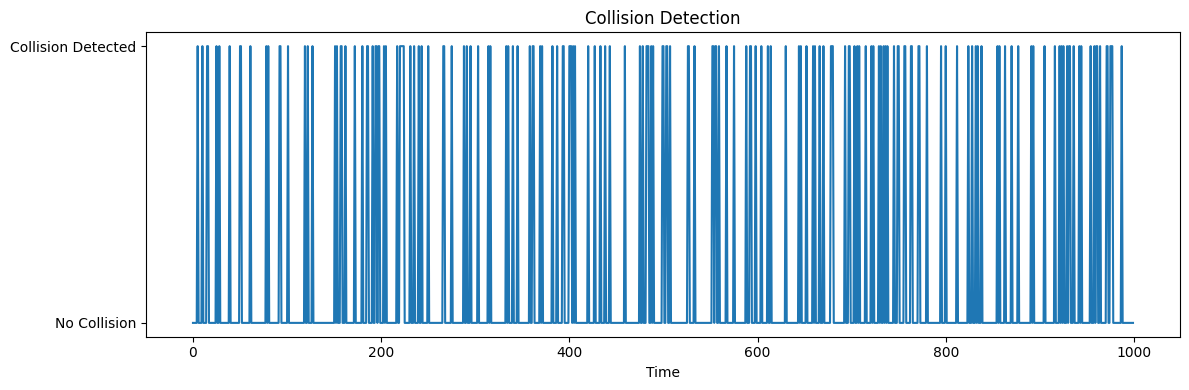

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(collisions, label="True collisions")
plt.xlabel("Time")
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.title("Collision Detection")
# plt.legend()
plt.tight_layout()
plt.show()

# Step 3: Train a Model

Train a DL model (*e.g.* RNN or transformed) to classify collision likelihood from the observable signal.

We keep the input as a sliding window of emissions (past n steps).
We also use a lightweight Transformer encoder to process sequences.

The model is trained as a binary classifier: collision (1) vs no collision (0).

In [10]:
n_context = 10  # number of time steps to consider in the classification

In [11]:
T_effective = T - n_context + 1

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def extract_features_with_silence(emissions, active_devices, collisions, n_context):
    X = []
    y = []

    for t in range(n_context - 1, len(emissions)):
        window = emissions[t - n_context + 1 : t + 1]
        window_dev = np.diff(window, prepend=window[0])
        window_mean = np.mean(window)
        window_std = np.std(window)
        active_window = active_devices[t - n_context + 1 : t + 1]

        # Time since last zero emission in the window
        reversed_window = window[::-1]
        try:
            last_zero_idx = np.where(reversed_window == 0)[0][0]
            time_since_zero = last_zero_idx
        except IndexError:
            time_since_zero = n_context  # No zero in window

        features = np.concatenate([
            window,                      # n_context
            window_dev,                  # n_context
            [window_mean, window_std],   # 2
            active_window,               # n_context
            [time_since_zero]            # 1
        ])
        X.append(features)
        y.append(collisions[t])

    # This yields a final feature vector of:
    # 3 × n_context + 3  = input_dim of the model
    return np.array(X), np.array(y)

In [14]:
# Create input features
X, y = extract_features_with_silence(total_emission, active_devices, collisions, n_context)

In [15]:
# Split into train/test

split = int(0.8 * len(X))
X_train = torch.tensor(X[:split], dtype=torch.float32).unsqueeze(-1).to(device)  # [B, T, 1]
y_train = torch.tensor(y[:split], dtype=torch.float32).to(device)

X_test = torch.tensor(X[split:], dtype=torch.float32).unsqueeze(-1).to(device)
y_test = torch.tensor(y[split:], dtype=torch.float32).to(device)

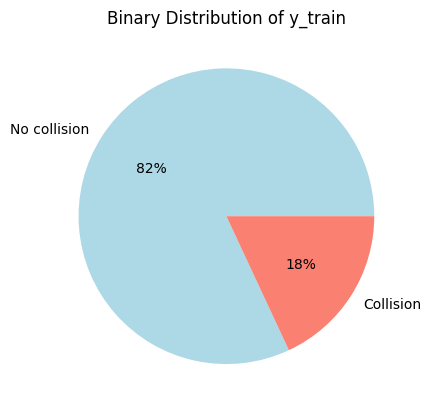

In [16]:
# Count occurrences of each category
labels, counts = np.unique(y_train.cpu().numpy(), return_counts=True)

# Create pie chart
plt.pie(counts, labels=["No collision" if int(x) == 0 else "Collision" for x in labels], autopct='%1.0f%%', colors=['lightblue', 'salmon'])

# Add title
plt.title('Binary Distribution of y_train')
plt.show()

## Model

In [17]:
# Transformer-based model
class CollisionMLP(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.net(x)).squeeze(-1)

In [18]:
X_train = X_train.squeeze(dim=-1)
X_test = X_test.squeeze(dim=-1)

In [19]:
# Instantiate
lr = 0.0001

model = CollisionMLP(input_size=X_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# to try to fix unbalanced data
pos_weight = torch.tensor([ (y_train == 0).sum() / (y_train == 1).sum() ]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Note: Remove sigmoid from model!

In [20]:
X_train.shape

torch.Size([792, 33])

In [21]:
# Training loop
epochs = 5000
losses = []
n_steps_show = epochs // 10
for epoch in tqdm(range(epochs)):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch + 1) % n_steps_show == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

 12%|█████████▏                                                                     | 580/5000 [00:00<00:05, 789.81it/s]

Epoch 500, Loss: 0.9350


 22%|█████████████████▎                                                            | 1113/5000 [00:01<00:05, 670.34it/s]

Epoch 1000, Loss: 0.8738


 33%|█████████████████████████▍                                                    | 1634/5000 [00:02<00:05, 630.19it/s]

Epoch 1500, Loss: 0.8450


 43%|█████████████████████████████████▌                                            | 2155/5000 [00:03<00:03, 751.60it/s]

Epoch 2000, Loss: 0.8325


 52%|████████████████████████████████████████▊                                     | 2614/5000 [00:03<00:03, 758.58it/s]

Epoch 2500, Loss: 0.8274


 63%|█████████████████████████████████████████████████▍                            | 3168/5000 [00:04<00:02, 805.33it/s]

Epoch 3000, Loss: 0.8260


 72%|███████████████████████████████████████████████████████▉                      | 3584/5000 [00:05<00:01, 813.30it/s]

Epoch 3500, Loss: 0.8254


 83%|████████████████████████████████████████████████████████████████▉             | 4162/5000 [00:05<00:01, 809.26it/s]

Epoch 4000, Loss: 0.8251


 93%|████████████████████████████████████████████████████████████████████████▋     | 4661/5000 [00:06<00:00, 834.35it/s]

Epoch 4500, Loss: 0.8250


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 727.89it/s]

Epoch 5000, Loss: 0.8249


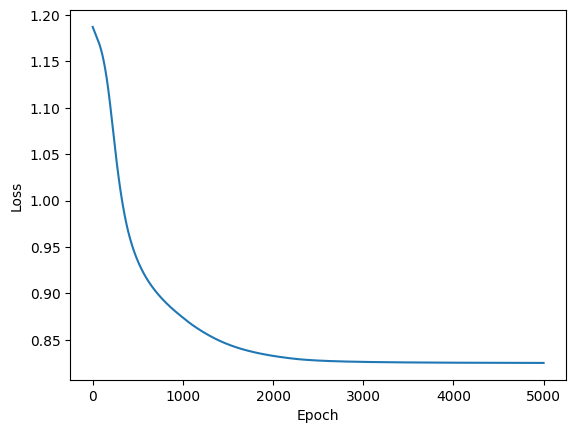

In [22]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [23]:
# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    y_pred_cls = (y_pred > 0.5).astype(int)
    y_true = y_test.cpu().numpy()

print(classification_report(y_true, y_pred_cls))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       164
         1.0       1.00      0.94      0.97        35

    accuracy                           0.99       199
   macro avg       0.99      0.97      0.98       199
weighted avg       0.99      0.99      0.99       199



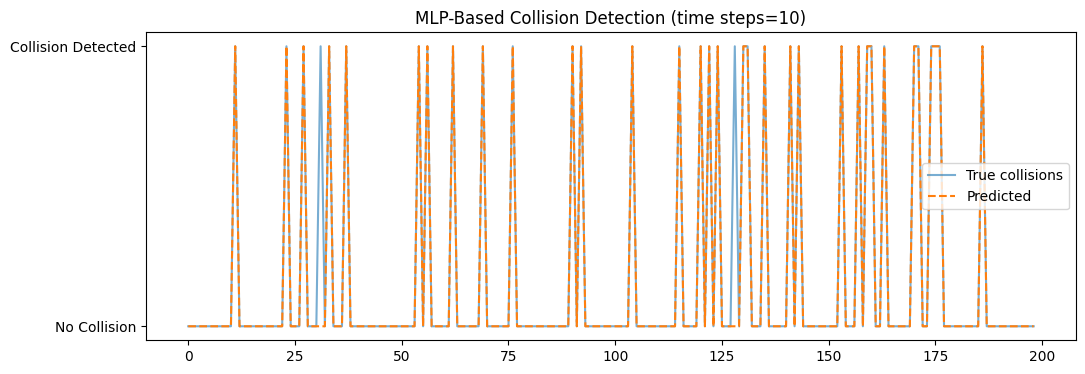

In [24]:
# Plot results
plt.figure(figsize=(12, 4))
plt.plot(y_true, label="True collisions", alpha=0.6)
plt.plot(y_pred_cls, label="Predicted", linestyle='--')
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.legend()
plt.title(f"MLP-Based Collision Detection (time steps={n_context})")
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("AUC:", roc_auc_score(y_test.cpu(), y_pred_cls))
print("PR AUC:", average_precision_score(y_test.cpu(), y_pred_cls))

AUC: 0.9714285714285714
PR AUC: 0.9529073941134243


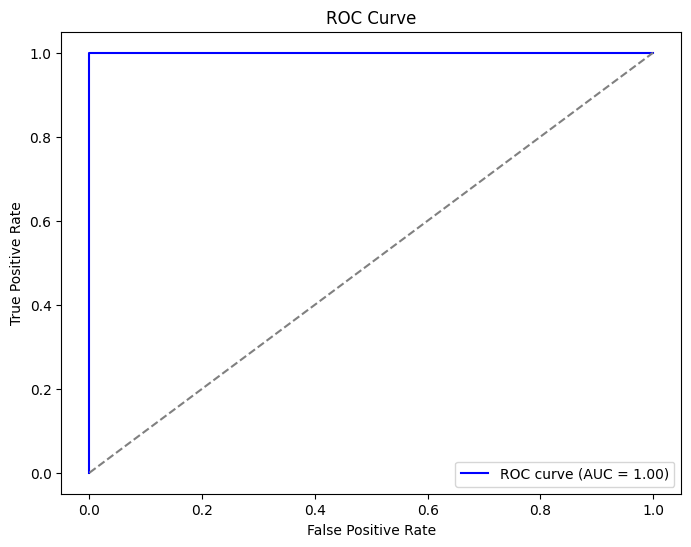

In [26]:
from sklearn.metrics import roc_curve, auc

y_scores = torch.sigmoid(torch.tensor(y_pred)).numpy() 

fpr, tpr, _ = roc_curve(y_test.cpu(), y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

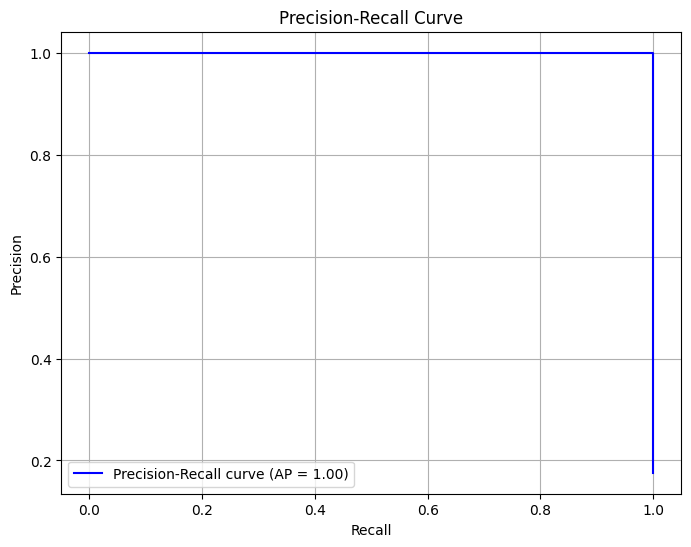

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test.cpu(), y_scores)

# Compute Average Precision (AP) score
ap_score = average_precision_score(y_test.cpu(), y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()